In [1]:
# %%
from pathlib import Path

import torch
import numpy as np
import random
import pickle
from absl import logging
from absl.flags import FLAGS
from cellot import losses
from cellot.utils.loaders import load
from cellot.models.cellot import compute_loss_f, compute_loss_g, compute_w2_distance
from cellot.train.summary import Logger
from cellot.data.utils import cast_loader_to_iterator
from cellot.models.ae import compute_scgen_shift
from tqdm import trange

from cellot.models.ae import AutoEncoder

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
logger = logging.getLogger("data_logger")
logger.setLevel(logging.INFO)


In [2]:
DEBUG = True
TARGET = 'all' if not DEBUG else 'abexinostat'
LATENT_DIM = 1

from pathlib import Path
outdir_path = '/Mounts/rbg-storage1/users/johnyang/cellot/results/sciplex3/full_ae'
outdir = Path(outdir_path)

# %%
outdir.mkdir(exist_ok=True, parents=True)

cachedir = outdir / "cache"
cachedir.mkdir(exist_ok=True)

In [3]:

import torch
import GPUtil
import os

def get_free_gpu():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    # Set environment variables for which GPUs to use.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    chosen_gpu = ''.join(
        [str(x) for x in GPUtil.getAvailable(order='memory')])
    os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu
    print(f"Using GPUs: {chosen_gpu}")
    return chosen_gpu

status = cachedir / "status"
status.write_text("running")

device = f'cuda:{get_free_gpu()}'

cuda
Using GPUs: 1


In [4]:

# %%
import omegaconf

if DEBUG:
    n_iters = 250000
    batch_size = 256
else:
    n_iters = 250000
    batch_size = 256

yaml_str = f"""
model:
   name: scgen
   beta: 0.0
   dropout: 0.0
   hidden_units: [512, 512]
   latent_dim: 50

optim:
   lr: 0.001
   optimizer: Adam
   weight_decay: 1.0e-05

scheduler:
   gamma: 0.5
   step_size: 100000

training:
  cache_freq: 10000
  eval_freq: 2500
  logs_freq: 250
  n_iters: {n_iters}

data:
  type: cell
  source: control
  condition: drug
  path: /Mounts/rbg-storage1/users/johnyang/cellot/datasets/scrna-sciplex3/hvg.h5ad
  target: {TARGET}

datasplit:
    groupby: drug   
    name: train_test
    test_size: 0.2
    random_state: 0

dataloader:
    batch_size: {batch_size}
    shuffle: true
"""

config = omegaconf.OmegaConf.create(yaml_str)


In [5]:

# %% [markdown]
# ### Utils

# %%
def load_lr_scheduler(optim, config):
    if "scheduler" not in config:
        return None

    return torch.optim.lr_scheduler.StepLR(optim, **config.scheduler)

def check_loss(*args):
    for arg in args:
        if torch.isnan(arg):
            raise ValueError


def load_item_from_save(path, key, default):
    path = Path(path)
    if not path.exists():
        return default

    ckpt = torch.load(path)
    if key not in ckpt:
        logging.warn(f"'{key}' not found in ckpt: {str(path)}")
        return default

    return ckpt[key]

# %%
import cellot.models
from cellot.data.cell import load_cell_data


def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, device, restore=None, **kwargs):
    # def load_autoencoder_model(config, restore=None, **kwargs):
    
    def load_optimizer(config, params):
        kwargs = dict(config.get("optim", {}))
        assert kwargs.pop("optimizer", "Adam") == "Adam"
        optim = torch.optim.Adam(params, **kwargs)
        return optim


    def load_networks(config, **kwargs):
        kwargs = kwargs.copy()
        kwargs.update(dict(config.get("model", {})))
        name = kwargs.pop("name")

        if name == "scgen":
            model = AutoEncoder

        # elif name == "cae":
        #     model = ConditionalAutoEncoder
        else:
            raise ValueError

        return model(**kwargs)
    
    model = load_networks(config, **kwargs)
    optim = load_optimizer(config, model.parameters())

    if restore is not None and Path(restore).exists():
        print('Loading model from checkpoint')
        ckpt = torch.load(restore, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optim.load_state_dict(ckpt["optim_state"])
        if config.model.name == "scgen" and "code_means" in ckpt:
            model.code_means = ckpt["code_means"]
            
    # logger.info(f'Model on device {next(model.parameters()).device}')

    return model, optim

def load(config, device, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, device, restore=restore, **model_kwargs)

    # if include_model_kwargs:
    #     return model, opt, loader, model_kwargs

    return model, opt, loader

# %% [markdown]
# ### Training


In [6]:
def state_dict(model, optim, **kwargs):
    state = {
        "model_state": model.state_dict(),
        "optim_state": optim.state_dict(),
    }

    if hasattr(model, "code_means"):
        state["code_means"] = model.code_means

    state.update(kwargs)

    return state

def evaluate(vinputs):
    with torch.no_grad():
        loss, comps, _ = model(vinputs)
        loss = loss.mean()
        comps = {k: v.mean().item() for k, v in comps._asdict().items()}
        check_loss(loss)
        logger.log("eval", loss=loss.item(), step=step, **comps)
    return loss

In [7]:
_, _, loader = load(config, 'cuda', restore=cachedir / "last.pt")

2023-06-28 13:36:18,326 Loaded cell data with TARGET abexinostat and OBS SHAPE (22070, 16)


Loading model from checkpoint


In [8]:
"""R^3 diffusion methods."""
import numpy as np
from scipy.special import gamma
import torch


class R3Diffuser:
    """VP-SDE diffuser class for translations."""

    def __init__(self, r3_conf):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self._r3_conf = r3_conf
        self.min_b = r3_conf.min_b
        self.max_b = r3_conf.max_b
        self.schedule = r3_conf.schedule
        self._score_scaling = r3_conf.score_scaling
        self.latent_dim = r3_conf.latent_dim

    def _scale(self, x):
        return x * self._r3_conf.coordinate_scaling

    def _unscale(self, x):
        return x / self._r3_conf.coordinate_scaling

    def b_t(self, t):
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'linear': 
            return self.min_b + t*(self.max_b - self.min_b)
        elif self.schedule == 'cosine':
            return self.max_b + 0.5*(self.min_b - self.max_b)*(1 + np.cos(t*np.pi))
        elif self.schedule == 'exponential':
            sigma = t * np.log10(self.max_b) + (1 - t) * np.log10(self.min_b)
            return 10 ** sigma
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')
    
    def diffusion_coef(self, t):
        """Time-dependent diffusion coefficient."""
        return np.sqrt(self.b_t(t))

    def drift_coef(self, x, t):
        """Time-dependent drift coefficient."""
        return -1/2 * self.b_t(t) * x

    def sample_ref(self, n_samples: float=1):
        return np.random.normal(size=(n_samples, self.latent_dim))

    def marginal_b_t(self, t):
        if self.schedule == 'linear':
            return t*self.min_b + (1/2)*(t**2)*(self.max_b-self.min_b)
        elif self.schedule == 'exponential': 
            return (self.max_b**t * self.min_b**(1-t) - self.min_b) / (
                np.log(self.max_b) - np.log(self.min_b))
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')

    def calc_trans_0(self, score_t, x_t, t, use_torch=True):
        beta_t = self.marginal_b_t(t)
        beta_t = beta_t[..., None, None]
        exp_fn = torch.exp if use_torch else np.exp
        cond_var = 1 - exp_fn(-beta_t)
        return (score_t * cond_var + x_t) / exp_fn(-1/2*beta_t)

    def forward(self, x_t_1: np.ndarray, t: float, num_t: int):
        """Samples marginal p(x(t) | x(t-1)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t_1 = self._scale(x_t_1)
        b_t = torch.tensor(self.marginal_b_t(t) / num_t).to(x_t_1.device)
        z_t_1 = torch.tensor(np.random.normal(size=x_t_1.shape)).to(x_t_1.device)
        x_t = torch.sqrt(1 - b_t) * x_t_1 + torch.sqrt(b_t) * z_t_1
        return x_t
    
    def distribution(self, x_t, score_t, t, mask, dt):
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        std = g_t * np.sqrt(dt)
        mu = x_t - (f_t - g_t**2 * score_t) * dt
        if mask is not None:
            mu *= mask[..., None]
        return mu, std

    def forward_marginal(self, x_0: np.ndarray, t: float):
        """Samples marginal p(x(t) | x(0)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_0 = self._scale(x_0)
        x_t = np.random.normal(
            loc=np.exp(-1/2*self.marginal_b_t(t)) * x_0,
            scale=np.sqrt(1 - np.exp(-self.marginal_b_t(t)))
        )
        score_t = self.score(x_t, x_0, t)
        x_t = self._unscale(x_t)
        return x_t, score_t

    def score_scaling(self, t: float):
        if self._score_scaling == 'var':
            return 1 / self.conditional_var(t)
        elif self._score_scaling == 'std':
            return 1 / np.sqrt(self.conditional_var(t))
        elif self._score_scaling == 'expected_norm':
            return np.sqrt(2) / (gamma(1.5) * np.sqrt(self.conditional_var(t)))
        else:
            raise ValueError(f'Unrecognized scaling {self._score_scaling}')

    def reverse(
            self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            center: bool=True,
            ode: bool=False,
            noise_scale: float=1.0,
        ):
        """Simulates the reverse SDE for 1 step

        Args:
            x_t: [..., 3] current positions at time t in angstroms.
            score_t: [..., 3] rotation score at time t.
            t: continuous time in [0, 1].
            dt: continuous step size in [0, 1].
            mask: True indicates which residues to diffuse.

        Returns:
            [..., 3] positions at next step t-1.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        if ode:
            # Probability flow ODE
            perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        else:
            # Usual stochastic dynamics
            z = noise_scale * np.random.normal(size=score_t.shape)
            perturb = (f_t - g_t**2 * score_t) * dt + g_t * np.sqrt(dt) * z

        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        x_t_1 = x_t - perturb
        if center:
            com = np.sum(x_t_1, axis=-2) / np.sum(mask, axis=-1)[..., None]
            x_t_1 -= com[..., None, :]
        x_t_1 = self._unscale(x_t_1)
        return x_t_1

    def conditional_var(self, t, use_torch=False):
        """Conditional variance of p(xt|x0).

        Var[x_t|x_0] = conditional_var(t)*I

        """
        if use_torch:
            return 1 - torch.exp(-self.marginal_b_t(t))
        return 1 - np.exp(-self.marginal_b_t(t))

    def score(self, x_t, x_0, t, use_torch=False, scale=False):
        if use_torch:
            exp_fn = torch.exp
        else:
            exp_fn = np.exp
        if scale:
            x_t = self._scale(x_t)
            x_0 = self._scale(x_0)
        return -(x_t - exp_fn(-1/2*self.marginal_b_t(t)) * x_0) / self.conditional_var(t, use_torch=use_torch)

In [9]:
from omegaconf import OmegaConf

r3_conf = OmegaConf.create({
    'min_b': 0.01,
    'max_b': 1.0,
    'schedule': 'linear',
    'score_scaling': 'var',
    'coordinate_scaling': 1.0,
    'latent_dim': LATENT_DIM,
})

In [10]:
diffuser = R3Diffuser(r3_conf)

In [11]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Linear
import torch.nn as nn

In [12]:
model_dim = 64
num_layers = 2
nhead = 1
dim_feedforward = 128
dropout = 0.1 if not DEBUG else 0.0

import torch.nn as nn
import torch.nn.functional as F
import math
import functools as fn

class FeedForward(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, output_dim=50):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def get_timestep_embedding(timesteps, embedding_dim, max_positions=10000):
    # Code from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
    assert len(timesteps.shape) == 1
    timesteps = timesteps * max_positions
    half_dim = embedding_dim // 2
    emb = math.log(max_positions) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), mode='constant')
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

class ScoreNetwork(nn.Module):
    def __init__(self):
        super(ScoreNetwork, self).__init__()
        
        self.latent_dim = LATENT_DIM
        self.model_dim = model_dim
        self.dropout = dropout
        print(f'Dropout is {self.dropout}')
        self.embed_code_and_t = nn.Linear(LATENT_DIM + model_dim, model_dim)
        self.trmr_layer = TransformerEncoderLayer(d_model=model_dim, nhead=8, dim_feedforward=2048, dropout=dropout)
        self.pred_score = FeedForward(input_dim=model_dim, hidden_dim=64, output_dim=LATENT_DIM)
        self.model = nn.ModuleList([self.embed_code_and_t, *[self.trmr_layer for _ in range(num_layers)], self.pred_score])
        
        self.timestep_embedder = fn.partial(
            get_timestep_embedding,
            embedding_dim=self.model_dim,
            # max_positions=100
        )

    def forward(self, x, t):
        device = x.device
        B, C = x.shape
        t_embed = torch.tile(self.timestep_embedder(torch.tensor([t]).to(device)), dims=[B, 1])
        
        x = torch.cat([x, t_embed], dim=-1).to(device)
        
        for module in self.model[:-1]:  # iterate over all modules except the last one
            x = module(x)
        x = self.model[-1](x.squeeze(0))  # pass through the last module (FeedForward)
        return x

In [13]:
score_network = ScoreNetwork().to(device)

Dropout is 0.0


In [14]:
sum(p.numel() for p in score_network.parameters())

289601

In [15]:
optimizer = torch.optim.Adam(score_network.parameters(), lr=1e-4)

In [16]:
STEP = 0
ticker = trange(STEP, n_iters, initial=STEP, total=n_iters)

  0%|          | 0/250000 [00:00<?, ?it/s]

In [17]:
if DEBUG:
    ex_batch = torch.load('/Mounts/rbg-storage1/users/johnyang/cellot/ex_batch_sciplex3.pt').to(device)
    print('MEMORIZING MODEEEE')
else:
    print('NOT memorizing')

MEMORIZING MODEEEE


In [18]:
iterator = cast_loader_to_iterator(loader, cycle_all=True)

In [19]:
inputs = next(iterator.train).to(device)
inputs.shape

torch.Size([256, 1000])

In [20]:
# ae.to(device)

In [21]:
# with torch.no_grad():
#     ex_code = ae.encode(ex_batch).to(device)[None, 0, :1]

In [22]:
# ex_code

In [23]:
ex_code = torch.ones((1, 1)).to(device)

In [24]:
ex_code.shape

torch.Size([1, 1])

In [25]:
min_t = 0.0
rng = np.random.default_rng(42)

In [26]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/6.29.23_2')


In [27]:
import torch
torch.__version__

'2.0.1'

In [28]:
def eval(dt=0.001):
    score_network.eval()
    # log_freq = (1 / dt) / 100
    with torch.no_grad():
        x_t, _ = diffuser.forward_marginal(ex_code.detach().cpu().numpy(), t=1.0)
        
        for i, t in enumerate(np.arange(1.0, 0, -dt)):
            # if i % log_freq == 0:
                # print(x_t)
            x_t = torch.tensor(x_t).float().to(device)
            pred_score = score_network(x_t, t)
            
            # pred_scores.append(pred_score)
            # gt_scores.append(gt_score)
            
            # _, gt_score = diffuser.forward_marginal(ex_code.detach().cpu().numpy(), t=t)

            # print(pred_score, gt_score)
            
            x_t = diffuser.reverse(x_t=x_t.detach().cpu().numpy(), score_t=pred_score.detach().cpu().numpy(), t=t, dt=dt, center=False)
        
        x_0 = x_t
        writer.add_embedding(x_0, global_step=step, tag='reverse_sampled_x_0')
        writer.add_embedding(ex_code, global_step=step, tag='gt_x_0')
        writer.add_scalar('sampled x_0', x_0.item(), global_step=step)

In [29]:
eval_freq=1000
for step in ticker:

    score_network.train()
    
    # if DEBUG:
    #     inputs = ex_batch
    # else:
    #     raise NotImplementedError
    #     inputs = next(iterator.train)
    #     # inputs = inputs.to(device)
        
        
    optimizer.zero_grad()
    # '''
    # Get encoded representation
    # '''
    
    # code = ae.encode(inputs)
    
    t = rng.uniform(min_t, 1.0)
    x_t, gt_score_t = diffuser.forward_marginal(ex_code.detach().cpu().numpy(), t=t)
    
    score_scaling = torch.tensor(diffuser.score_scaling(t)).to(device)
    gt_score_t = torch.tensor(gt_score_t).to(device)
    
    pred_score_t = score_network(torch.tensor(x_t).float().to(device), t)

    score_mse = (gt_score_t - pred_score_t)**2
    score_loss = torch.sum(
        score_mse / score_scaling[None, None]**2,
        dim=(-1, -2)
    ) #/ (loss_mask.sum(dim=-1) + 1e-10)    
    
    # comps = {k: v.mean().item() for k, v in comps._asdict().items()}
    score_loss.backward()
    optimizer.step()
    # check_loss(score_)

    if step % config.training.logs_freq == 0:
        # log to logger object
        # logger.log("train", loss=loss.item(), step=step, **comps)
        writer.add_scalar('Training loss', score_loss.item(), global_step=step)
        print(f'At step {step}, TRAINING loss is {score_loss.item()}')
        
    if step % eval_freq == 0:
        eval()

At step 0, TRAINING loss is 0.011111482239258421


  0%|          | 253/250000 [00:52<4:18:22, 16.11it/s] 

At step 250, TRAINING loss is 0.37572293911707505


  0%|          | 503/250000 [01:08<4:21:42, 15.89it/s]

At step 500, TRAINING loss is 0.17507637523971165


  0%|          | 753/250000 [01:23<4:28:10, 15.49it/s]

At step 750, TRAINING loss is 0.029526436540580587


  0%|          | 999/250000 [01:39<4:15:43, 16.23it/s]

At step 1000, TRAINING loss is 0.001217812855422147


  1%|          | 1253/250000 [02:13<4:19:13, 15.99it/s]  

At step 1250, TRAINING loss is 0.013575531799537613


  1%|          | 1503/250000 [02:28<4:16:41, 16.13it/s]

At step 1500, TRAINING loss is 0.014520365294600369


  1%|          | 1753/250000 [02:44<4:46:06, 14.46it/s]

At step 1750, TRAINING loss is 0.02478085084298618


  1%|          | 1999/250000 [02:59<4:17:40, 16.04it/s]

At step 2000, TRAINING loss is 0.13039476028318395


  1%|          | 2253/250000 [03:33<4:14:37, 16.22it/s]  

At step 2250, TRAINING loss is 0.0636031635752245


  1%|          | 2503/250000 [03:49<4:24:02, 15.62it/s]

At step 2500, TRAINING loss is 0.0005059783987574045


  1%|          | 2753/250000 [04:04<4:17:49, 15.98it/s]

At step 2750, TRAINING loss is 0.0004756541427235294


  1%|          | 2999/250000 [04:20<4:06:39, 16.69it/s]

At step 3000, TRAINING loss is 0.014813143779099926


  1%|▏         | 3253/250000 [04:53<4:09:47, 16.46it/s]  

At step 3250, TRAINING loss is 0.009368731167508243


  1%|▏         | 3503/250000 [05:09<4:23:52, 15.57it/s]

At step 3500, TRAINING loss is 0.0003045278730302218


  2%|▏         | 3753/250000 [05:24<4:19:09, 15.84it/s]

At step 3750, TRAINING loss is 0.001303702462982149


  2%|▏         | 3999/250000 [05:40<4:12:42, 16.22it/s]

At step 4000, TRAINING loss is 0.02306755544244542


  2%|▏         | 4253/250000 [06:14<4:25:48, 15.41it/s]  

At step 4250, TRAINING loss is 0.00933485526400987


  2%|▏         | 4503/250000 [06:30<4:17:48, 15.87it/s]

At step 4500, TRAINING loss is 0.0013242062451352184


  2%|▏         | 4753/250000 [06:46<4:14:55, 16.03it/s]

At step 4750, TRAINING loss is 0.01953714031599575


  2%|▏         | 4999/250000 [07:01<4:09:46, 16.35it/s]

At step 5000, TRAINING loss is 0.0014811528461962055


  2%|▏         | 5253/250000 [07:35<4:42:21, 14.45it/s]  

At step 5250, TRAINING loss is 0.0010363541446516693


  2%|▏         | 5503/250000 [07:51<4:40:15, 14.54it/s]

At step 5500, TRAINING loss is 0.024411300494536454


  2%|▏         | 5753/250000 [08:06<4:14:57, 15.97it/s]

At step 5750, TRAINING loss is 0.00014652052057393444


  2%|▏         | 5999/250000 [08:21<4:13:43, 16.03it/s]

At step 6000, TRAINING loss is 0.008268362813106417


  3%|▎         | 6253/250000 [08:55<4:06:01, 16.51it/s]  

At step 6250, TRAINING loss is 2.028032687811369e-05


  3%|▎         | 6503/250000 [09:11<4:15:07, 15.91it/s]

At step 6500, TRAINING loss is 0.012786273104211956


  3%|▎         | 6753/250000 [09:26<4:14:30, 15.93it/s]

At step 6750, TRAINING loss is 3.7580101098229225e-08


  3%|▎         | 6999/250000 [09:41<4:06:06, 16.46it/s]

At step 7000, TRAINING loss is 0.031609182492461176


  3%|▎         | 7253/250000 [10:15<4:17:32, 15.71it/s]  

At step 7250, TRAINING loss is 0.0005112445788239207


  3%|▎         | 7503/250000 [10:30<4:17:00, 15.73it/s]

At step 7500, TRAINING loss is 0.014435252953518577


  3%|▎         | 7753/250000 [10:46<4:32:38, 14.81it/s]

At step 7750, TRAINING loss is 5.305579990213525e-05


  3%|▎         | 7999/250000 [11:01<4:09:36, 16.16it/s]

At step 8000, TRAINING loss is 0.0011592066436730377


  3%|▎         | 8253/250000 [11:35<4:10:59, 16.05it/s]  

At step 8250, TRAINING loss is 0.0015834704960352014


  3%|▎         | 8503/250000 [11:51<4:17:23, 15.64it/s]

At step 8500, TRAINING loss is 0.0001663793515276705


  4%|▎         | 8753/250000 [12:06<4:06:55, 16.28it/s]

At step 8750, TRAINING loss is 4.6154853319936204e-08


  4%|▎         | 8999/250000 [12:21<4:08:00, 16.20it/s]

At step 9000, TRAINING loss is 0.0011810982660924619


  4%|▎         | 9253/250000 [12:56<4:39:20, 14.36it/s]  

At step 9250, TRAINING loss is 0.022225551720022215


  4%|▍         | 9503/250000 [13:11<4:39:06, 14.36it/s]

At step 9500, TRAINING loss is 0.004505092842353885


  4%|▍         | 9753/250000 [13:27<4:16:24, 15.62it/s]

At step 9750, TRAINING loss is 0.0005081966329232871


  4%|▍         | 9999/250000 [13:43<4:20:28, 15.36it/s]

At step 10000, TRAINING loss is 0.004127806040756167


  4%|▍         | 10253/250000 [14:17<4:28:37, 14.88it/s]  

At step 10250, TRAINING loss is 0.07428242879345912


  4%|▍         | 10503/250000 [14:33<4:28:08, 14.89it/s]

At step 10500, TRAINING loss is 0.003547777645333179


  4%|▍         | 10753/250000 [14:49<4:14:03, 15.69it/s]

At step 10750, TRAINING loss is 0.0008002670072248381


  4%|▍         | 10999/250000 [15:04<4:05:27, 16.23it/s]

At step 11000, TRAINING loss is 0.0002863266372625771


  5%|▍         | 11253/250000 [15:38<4:14:11, 15.65it/s]  

At step 11250, TRAINING loss is 0.00028290518057874127


  5%|▍         | 11503/250000 [15:54<4:06:30, 16.13it/s]

At step 11500, TRAINING loss is 0.0006930324105960256


  5%|▍         | 11753/250000 [16:09<4:01:49, 16.42it/s]

At step 11750, TRAINING loss is 0.017460253056972054


  5%|▍         | 11999/250000 [16:24<4:33:50, 14.48it/s]

At step 12000, TRAINING loss is 0.047144699331589095


  5%|▍         | 12253/250000 [16:59<4:03:34, 16.27it/s]  

At step 12250, TRAINING loss is 0.00038898380309409006


  5%|▌         | 12503/250000 [17:14<4:11:03, 15.77it/s]

At step 12500, TRAINING loss is 0.005092034124714728


  5%|▌         | 12753/250000 [17:30<3:58:02, 16.61it/s]

At step 12750, TRAINING loss is 0.0004165825315902861


  5%|▌         | 12999/250000 [17:45<4:02:52, 16.26it/s]

At step 13000, TRAINING loss is 0.0035908852852204994


  5%|▌         | 13253/250000 [18:19<4:13:59, 15.53it/s]  

At step 13250, TRAINING loss is 0.00017719834061782327


  5%|▌         | 13503/250000 [18:35<4:12:10, 15.63it/s]

At step 13500, TRAINING loss is 0.0007250443841188715


  6%|▌         | 13753/250000 [18:50<4:04:16, 16.12it/s]

At step 13750, TRAINING loss is 0.0006587041830623256


  6%|▌         | 13999/250000 [19:06<4:06:33, 15.95it/s]

At step 14000, TRAINING loss is 0.0007178569137961672


  6%|▌         | 14253/250000 [19:40<4:21:45, 15.01it/s]  

At step 14250, TRAINING loss is 0.0013207520952683322


  6%|▌         | 14503/250000 [19:56<3:59:34, 16.38it/s]

At step 14500, TRAINING loss is 6.3627098863797636e-06


  6%|▌         | 14753/250000 [20:12<4:04:23, 16.04it/s]

At step 14750, TRAINING loss is 0.003833200006854065


  6%|▌         | 14999/250000 [20:27<3:55:50, 16.61it/s]

At step 15000, TRAINING loss is 0.0005474591055964614


  6%|▌         | 15253/250000 [21:01<4:07:26, 15.81it/s]  

At step 15250, TRAINING loss is 0.003552610617097901


  6%|▌         | 15503/250000 [21:16<4:31:16, 14.41it/s]

At step 15500, TRAINING loss is 0.00015488002739184808


  6%|▋         | 15753/250000 [21:32<4:12:12, 15.48it/s]

At step 15750, TRAINING loss is 3.2055280995834745e-05


  6%|▋         | 15999/250000 [21:47<3:53:08, 16.73it/s]

At step 16000, TRAINING loss is 6.617802706671977e-05


  7%|▋         | 16253/250000 [22:21<4:21:21, 14.91it/s]  

At step 16250, TRAINING loss is 3.9903468970181185e-05


  7%|▋         | 16503/250000 [22:37<4:06:13, 15.81it/s]

At step 16500, TRAINING loss is 0.0074107718878833094


  7%|▋         | 16753/250000 [22:53<4:00:44, 16.15it/s]

At step 16750, TRAINING loss is 0.00029585911402061894


  7%|▋         | 16999/250000 [23:08<3:53:18, 16.64it/s]

At step 17000, TRAINING loss is 0.002904608821082689


  7%|▋         | 17253/250000 [23:42<4:03:16, 15.95it/s]  

At step 17250, TRAINING loss is 0.0029576209458243258


  7%|▋         | 17503/250000 [23:58<3:53:05, 16.62it/s]

At step 17500, TRAINING loss is 0.0035385680258424317


  7%|▋         | 17753/250000 [24:13<4:05:49, 15.75it/s]

At step 17750, TRAINING loss is 0.0003665339301404792


  7%|▋         | 17999/250000 [24:28<3:52:27, 16.63it/s]

At step 18000, TRAINING loss is 0.0015528535588474636


  7%|▋         | 18253/250000 [25:02<4:00:56, 16.03it/s]  

At step 18250, TRAINING loss is 1.577167773011318e-05


  7%|▋         | 18503/250000 [25:17<3:52:05, 16.62it/s]

At step 18500, TRAINING loss is 0.008241432823483363


  8%|▊         | 18753/250000 [25:33<3:57:40, 16.22it/s]

At step 18750, TRAINING loss is 0.00611592221832802


  8%|▊         | 18999/250000 [25:48<4:07:31, 15.55it/s]

At step 19000, TRAINING loss is 5.865960861708434e-05


  8%|▊         | 19253/250000 [26:23<4:09:38, 15.41it/s]  

At step 19250, TRAINING loss is 0.004343487478956376


  8%|▊         | 19503/250000 [26:39<4:17:51, 14.90it/s]

At step 19500, TRAINING loss is 0.007786400634990083


  8%|▊         | 19753/250000 [26:55<4:28:05, 14.31it/s]

At step 19750, TRAINING loss is 2.4718300650645834e-05


  8%|▊         | 19999/250000 [27:11<4:08:26, 15.43it/s]

At step 20000, TRAINING loss is 0.00043191977199673716


  8%|▊         | 20253/250000 [27:46<3:55:52, 16.23it/s]  

At step 20250, TRAINING loss is 0.0029272985564839623


  8%|▊         | 20503/250000 [28:02<4:11:40, 15.20it/s]

At step 20500, TRAINING loss is 0.0009099619519931535


  8%|▊         | 20753/250000 [28:18<4:02:34, 15.75it/s]

At step 20750, TRAINING loss is 0.0002191736232643566


  8%|▊         | 20999/250000 [28:34<4:11:55, 15.15it/s]

At step 21000, TRAINING loss is 0.0051829758124050905


  9%|▊         | 21253/250000 [29:08<3:58:24, 15.99it/s]  

At step 21250, TRAINING loss is 4.08726838195794e-06


  9%|▊         | 21503/250000 [29:24<4:07:29, 15.39it/s]

At step 21500, TRAINING loss is 0.00029471408425556553


  9%|▊         | 21753/250000 [29:40<3:51:23, 16.44it/s]

At step 21750, TRAINING loss is 0.020178126376767896


  9%|▉         | 21999/250000 [29:55<3:58:48, 15.91it/s]

At step 22000, TRAINING loss is 0.0023431797701951177


  9%|▉         | 22253/250000 [30:29<3:54:58, 16.15it/s]  

At step 22250, TRAINING loss is 0.0012011315475131026


  9%|▉         | 22503/250000 [30:45<3:57:59, 15.93it/s]

At step 22500, TRAINING loss is 0.004701094190121871


  9%|▉         | 22753/250000 [31:01<4:12:14, 15.02it/s]

At step 22750, TRAINING loss is 0.019439279215308327


  9%|▉         | 22999/250000 [31:17<3:52:09, 16.30it/s]

At step 23000, TRAINING loss is 0.00019422015380129523


  9%|▉         | 23253/250000 [31:51<4:21:11, 14.47it/s]  

At step 23250, TRAINING loss is 3.249531201213474e-05


  9%|▉         | 23503/250000 [32:06<3:47:17, 16.61it/s]

At step 23500, TRAINING loss is 0.0005894558453868713


 10%|▉         | 23753/250000 [32:22<4:02:01, 15.58it/s]

At step 23750, TRAINING loss is 0.002691674408682648


 10%|▉         | 23999/250000 [32:37<3:49:37, 16.40it/s]

At step 24000, TRAINING loss is 0.0001752957854459698


 10%|▉         | 24253/250000 [33:11<4:04:44, 15.37it/s]  

At step 24250, TRAINING loss is 2.5016112410775552e-05


 10%|▉         | 24503/250000 [33:27<3:51:22, 16.24it/s]

At step 24500, TRAINING loss is 6.637384867961784e-05


 10%|▉         | 24753/250000 [33:42<3:58:29, 15.74it/s]

At step 24750, TRAINING loss is 0.002041872152692026


 10%|▉         | 24999/250000 [33:58<3:57:23, 15.80it/s]

At step 25000, TRAINING loss is 0.012301453407746295


 10%|█         | 25253/250000 [34:33<3:53:51, 16.02it/s]  

At step 25250, TRAINING loss is 0.0006011290058233184


 10%|█         | 25503/250000 [34:49<3:53:09, 16.05it/s]

At step 25500, TRAINING loss is 0.009965702298020589


 10%|█         | 25753/250000 [35:05<4:00:41, 15.53it/s]

At step 25750, TRAINING loss is 2.729417435898443e-05


 10%|█         | 25999/250000 [35:21<3:56:23, 15.79it/s]

At step 26000, TRAINING loss is 0.0057989357321995465


 11%|█         | 26254/250000 [35:55<3:59:12, 15.59it/s]  

At step 26250, TRAINING loss is 0.00797395905369817


 11%|█         | 26504/250000 [36:11<3:50:52, 16.13it/s]

At step 26500, TRAINING loss is 0.006663004935922147


 11%|█         | 26754/250000 [36:27<3:58:50, 15.58it/s]

At step 26750, TRAINING loss is 0.00025263694273131005


 11%|█         | 27000/250000 [36:42<4:02:45, 15.31it/s]

At step 27000, TRAINING loss is 0.0001676546907411563


 11%|█         | 27253/250000 [37:17<3:48:07, 16.27it/s]  

At step 27250, TRAINING loss is 0.003262765962788794


 11%|█         | 27503/250000 [37:32<3:44:28, 16.52it/s]

At step 27500, TRAINING loss is 0.00048415256042210896


 11%|█         | 27753/250000 [37:48<3:48:10, 16.23it/s]

At step 27750, TRAINING loss is 0.004704954738127823


 11%|█         | 27999/250000 [38:03<4:04:30, 15.13it/s]

At step 28000, TRAINING loss is 0.02799731066442163


 11%|█▏        | 28253/250000 [38:38<3:45:20, 16.40it/s]  

At step 28250, TRAINING loss is 0.003677192572024592


 11%|█▏        | 28503/250000 [38:53<3:53:48, 15.79it/s]

At step 28500, TRAINING loss is 0.0019707413823039335


 12%|█▏        | 28753/250000 [39:09<3:43:49, 16.47it/s]

At step 28750, TRAINING loss is 0.0015610415825541893


 12%|█▏        | 28999/250000 [39:24<3:41:29, 16.63it/s]

At step 29000, TRAINING loss is 0.0004239680347850038


 12%|█▏        | 29253/250000 [39:58<3:50:55, 15.93it/s]  

At step 29250, TRAINING loss is 0.0010642345043611853


 12%|█▏        | 29503/250000 [40:14<3:51:53, 15.85it/s]

At step 29500, TRAINING loss is 0.0003929730490936304


 12%|█▏        | 29753/250000 [40:29<3:45:46, 16.26it/s]

At step 29750, TRAINING loss is 0.014578037149532557


 12%|█▏        | 29999/250000 [40:44<3:48:50, 16.02it/s]

At step 30000, TRAINING loss is 0.002474423336809756


 12%|█▏        | 30253/250000 [41:19<4:10:05, 14.64it/s]  

At step 30250, TRAINING loss is 0.0017251169364356227


 12%|█▏        | 30503/250000 [41:34<3:46:49, 16.13it/s]

At step 30500, TRAINING loss is 0.0011012538993381675


 12%|█▏        | 30753/250000 [41:50<3:50:59, 15.82it/s]

At step 30750, TRAINING loss is 0.0011737135157232309


 12%|█▏        | 30999/250000 [42:06<3:48:46, 15.95it/s]

At step 31000, TRAINING loss is 2.6030127066705424e-05


 13%|█▎        | 31253/250000 [42:40<3:42:34, 16.38it/s]  

At step 31250, TRAINING loss is 0.0016127385245639323


 13%|█▎        | 31503/250000 [42:55<4:08:20, 14.66it/s]

At step 31500, TRAINING loss is 0.00023170000237380698


 13%|█▎        | 31753/250000 [43:11<3:51:59, 15.68it/s]

At step 31750, TRAINING loss is 6.995289075321828e-07


 13%|█▎        | 31999/250000 [43:26<3:47:14, 15.99it/s]

At step 32000, TRAINING loss is 0.0013997908443891475


 13%|█▎        | 32253/250000 [44:01<3:51:27, 15.68it/s]  

At step 32250, TRAINING loss is 0.003985065972843781


 13%|█▎        | 32503/250000 [44:17<3:45:49, 16.05it/s]

At step 32500, TRAINING loss is 8.21270792712765e-06


 13%|█▎        | 32753/250000 [44:32<3:49:41, 15.76it/s]

At step 32750, TRAINING loss is 0.00033903806105142694


 13%|█▎        | 32999/250000 [44:48<3:33:57, 16.90it/s]

At step 33000, TRAINING loss is 1.0925831245930922e-06


 13%|█▎        | 33253/250000 [45:22<3:48:18, 15.82it/s]  

At step 33250, TRAINING loss is 0.0004344682993149892


 13%|█▎        | 33503/250000 [45:38<3:50:30, 15.65it/s]

At step 33500, TRAINING loss is 0.00020966912046570073


 14%|█▎        | 33753/250000 [45:53<3:55:50, 15.28it/s]

At step 33750, TRAINING loss is 0.00017210798721603788


 14%|█▎        | 33999/250000 [46:09<3:51:26, 15.56it/s]

At step 34000, TRAINING loss is 0.004488977979781847


 14%|█▎        | 34253/250000 [46:43<3:43:02, 16.12it/s]  

At step 34250, TRAINING loss is 0.0010407438542585422


 14%|█▍        | 34503/250000 [46:58<3:35:57, 16.63it/s]

At step 34500, TRAINING loss is 0.00039113081067180947


 14%|█▍        | 34753/250000 [47:14<3:48:57, 15.67it/s]

At step 34750, TRAINING loss is 0.0038030825341224305


 14%|█▍        | 34999/250000 [47:29<3:39:11, 16.35it/s]

At step 35000, TRAINING loss is 9.504239589189426e-05


 14%|█▍        | 35253/250000 [48:04<3:48:01, 15.70it/s]  

At step 35250, TRAINING loss is 0.002863822056650274


 14%|█▍        | 35503/250000 [48:20<3:41:59, 16.10it/s]

At step 35500, TRAINING loss is 0.0006973598073504538


 14%|█▍        | 35753/250000 [48:35<3:41:41, 16.11it/s]

At step 35750, TRAINING loss is 1.45915910760569e-05


 14%|█▍        | 35999/250000 [48:51<3:41:54, 16.07it/s]

At step 36000, TRAINING loss is 0.00026486453791083444


 15%|█▍        | 36254/250000 [49:25<3:39:12, 16.25it/s]  

At step 36250, TRAINING loss is 0.0014481692937388664


 15%|█▍        | 36504/250000 [49:41<3:43:52, 15.89it/s]

At step 36500, TRAINING loss is 0.0026886878210016004


 15%|█▍        | 36754/250000 [49:57<3:44:09, 15.86it/s]

At step 36750, TRAINING loss is 9.112202981963893e-05


 15%|█▍        | 37000/250000 [50:12<3:57:53, 14.92it/s]

At step 37000, TRAINING loss is 0.0017004996280534969


 15%|█▍        | 37253/250000 [50:47<3:39:40, 16.14it/s]  

At step 37250, TRAINING loss is 0.0013469391915215396


 15%|█▌        | 37503/250000 [51:03<3:52:37, 15.22it/s]

At step 37500, TRAINING loss is 1.6619930192203917e-06


 15%|█▌        | 37753/250000 [51:19<3:44:16, 15.77it/s]

At step 37750, TRAINING loss is 0.001915679155307768


 15%|█▌        | 37999/250000 [51:34<3:37:24, 16.25it/s]

At step 38000, TRAINING loss is 0.0021105185056109295


 15%|█▌        | 38253/250000 [52:09<3:46:37, 15.57it/s]  

At step 38250, TRAINING loss is 0.0010505969897472648


 15%|█▌        | 38503/250000 [52:25<3:44:19, 15.71it/s]

At step 38500, TRAINING loss is 0.00047041282765398617


 16%|█▌        | 38753/250000 [52:40<3:35:57, 16.30it/s]

At step 38750, TRAINING loss is 0.016896553224850848


 16%|█▌        | 38999/250000 [52:56<3:38:47, 16.07it/s]

At step 39000, TRAINING loss is 0.0015004639050630651


 16%|█▌        | 39254/250000 [53:30<3:42:06, 15.81it/s]  

At step 39250, TRAINING loss is 0.0037095514025805207


 16%|█▌        | 39504/250000 [53:46<3:34:13, 16.38it/s]

At step 39500, TRAINING loss is 0.001069536340804398


 16%|█▌        | 39754/250000 [54:01<3:48:05, 15.36it/s]

At step 39750, TRAINING loss is 0.0011245391662596943


 16%|█▌        | 40000/250000 [54:17<3:27:09, 16.90it/s]

At step 40000, TRAINING loss is 0.0025406348038906636


 16%|█▌        | 40253/250000 [54:51<3:48:15, 15.32it/s]  

At step 40250, TRAINING loss is 0.00013827628228602529


 16%|█▌        | 40503/250000 [55:06<3:32:49, 16.41it/s]

At step 40500, TRAINING loss is 0.004357603636678461


 16%|█▋        | 40753/250000 [55:22<3:37:24, 16.04it/s]

At step 40750, TRAINING loss is 0.0008422186482324061


 16%|█▋        | 40999/250000 [55:37<3:28:45, 16.69it/s]

At step 41000, TRAINING loss is 5.775212034705874e-06


 17%|█▋        | 41253/250000 [56:11<3:30:15, 16.55it/s]  

At step 41250, TRAINING loss is 0.004067010666921391


 17%|█▋        | 41503/250000 [56:27<3:31:12, 16.45it/s]

At step 41500, TRAINING loss is 0.00029532323319104965


 17%|█▋        | 41753/250000 [56:42<3:47:35, 15.25it/s]

At step 41750, TRAINING loss is 0.0028854825827872455


 17%|█▋        | 41999/250000 [56:58<3:30:08, 16.50it/s]

At step 42000, TRAINING loss is 0.0008242588635223384


 17%|█▋        | 42254/250000 [57:33<3:37:57, 15.89it/s]  

At step 42250, TRAINING loss is 0.0003088743056324864


 17%|█▋        | 42504/250000 [57:48<3:36:37, 15.96it/s]

At step 42500, TRAINING loss is 0.001374251015113105


 17%|█▋        | 42754/250000 [58:04<3:36:08, 15.98it/s]

At step 42750, TRAINING loss is 0.015295410750760786


 17%|█▋        | 43000/250000 [58:19<3:32:42, 16.22it/s]

At step 43000, TRAINING loss is 0.00022837591964997058


 17%|█▋        | 43253/250000 [58:53<3:39:11, 15.72it/s]  

At step 43250, TRAINING loss is 0.00014948913733324457


 17%|█▋        | 43503/250000 [59:08<3:27:18, 16.60it/s]

At step 43500, TRAINING loss is 7.284368920217869e-05


 18%|█▊        | 43753/250000 [59:24<3:26:43, 16.63it/s]

At step 43750, TRAINING loss is 3.2876470329849084e-05


 18%|█▊        | 43999/250000 [59:39<3:26:29, 16.63it/s]

At step 44000, TRAINING loss is 0.00046043563716056154


 18%|█▊        | 44253/250000 [1:00:13<3:49:44, 14.93it/s]

At step 44250, TRAINING loss is 3.2108256254286176e-06


 18%|█▊        | 44503/250000 [1:00:28<3:37:15, 15.76it/s]

At step 44500, TRAINING loss is 1.5483286002809198e-05


 18%|█▊        | 44753/250000 [1:00:44<3:33:23, 16.03it/s]

At step 44750, TRAINING loss is 0.003255922575292254


 18%|█▊        | 44999/250000 [1:00:59<3:26:57, 16.51it/s]

At step 45000, TRAINING loss is 0.0025015536104499017


 18%|█▊        | 45252/250000 [1:01:33<3:58:28, 14.31it/s]  

At step 45250, TRAINING loss is 0.0008189584937584971


 18%|█▊        | 45504/250000 [1:01:49<3:39:42, 15.51it/s]

At step 45500, TRAINING loss is 0.00547090979956161


 18%|█▊        | 45754/250000 [1:02:05<3:27:48, 16.38it/s]

At step 45750, TRAINING loss is 0.002077597405906864


 18%|█▊        | 46000/250000 [1:02:20<3:34:57, 15.82it/s]

At step 46000, TRAINING loss is 0.0005160971412700116


 19%|█▊        | 46253/250000 [1:02:54<3:39:19, 15.48it/s]  

At step 46250, TRAINING loss is 0.000156366222567679


 19%|█▊        | 46503/250000 [1:03:10<3:37:07, 15.62it/s]

At step 46500, TRAINING loss is 3.1442400496166126e-05


 19%|█▊        | 46753/250000 [1:03:26<3:32:04, 15.97it/s]

At step 46750, TRAINING loss is 8.365643663040233e-05


 19%|█▉        | 46999/250000 [1:03:41<3:40:07, 15.37it/s]

At step 47000, TRAINING loss is 0.0009497148303850529


 19%|█▉        | 47253/250000 [1:04:16<3:35:55, 15.65it/s]  

At step 47250, TRAINING loss is 1.058829989928907e-05


 19%|█▉        | 47503/250000 [1:04:32<3:30:05, 16.06it/s]

At step 47500, TRAINING loss is 0.00023348265651332688


 19%|█▉        | 47753/250000 [1:04:47<3:35:39, 15.63it/s]

At step 47750, TRAINING loss is 4.1910174447476373e-07


 19%|█▉        | 47999/250000 [1:05:03<3:33:13, 15.79it/s]

At step 48000, TRAINING loss is 8.088970893693538e-05


 19%|█▉        | 48253/250000 [1:05:37<3:25:20, 16.37it/s]  

At step 48250, TRAINING loss is 0.000693661147001608


 19%|█▉        | 48503/250000 [1:05:52<3:33:26, 15.73it/s]

At step 48500, TRAINING loss is 0.002051988720011077


 20%|█▉        | 48753/250000 [1:06:08<3:27:06, 16.19it/s]

At step 48750, TRAINING loss is 6.094616084341926e-05


 20%|█▉        | 48999/250000 [1:06:24<3:43:59, 14.96it/s]

At step 49000, TRAINING loss is 0.0001771571849480374


 20%|█▉        | 49253/250000 [1:06:58<3:28:23, 16.05it/s]  

At step 49250, TRAINING loss is 0.00020385702051202125


 20%|█▉        | 49503/250000 [1:07:13<3:29:20, 15.96it/s]

At step 49500, TRAINING loss is 0.025768906848421588


 20%|█▉        | 49753/250000 [1:07:29<3:24:50, 16.29it/s]

At step 49750, TRAINING loss is 4.9584997402343156e-05


 20%|█▉        | 49999/250000 [1:07:44<3:18:39, 16.78it/s]

At step 50000, TRAINING loss is 2.7531742613238763e-05


 20%|██        | 50253/250000 [1:08:18<3:26:39, 16.11it/s]  

At step 50250, TRAINING loss is 7.439319538344173e-06


 20%|██        | 50503/250000 [1:08:34<3:25:59, 16.14it/s]

At step 50500, TRAINING loss is 3.331803692551376e-05


 20%|██        | 50753/250000 [1:08:49<3:21:26, 16.48it/s]

At step 50750, TRAINING loss is 0.0016786358433542906


 20%|██        | 50999/250000 [1:09:05<3:24:43, 16.20it/s]

At step 51000, TRAINING loss is 0.0010952539680606549


 21%|██        | 51253/250000 [1:09:39<3:24:11, 16.22it/s]  

At step 51250, TRAINING loss is 0.00013786229461434327


 21%|██        | 51503/250000 [1:09:54<3:39:19, 15.08it/s]

At step 51500, TRAINING loss is 0.00026081375256590075


 21%|██        | 51753/250000 [1:10:10<3:24:59, 16.12it/s]

At step 51750, TRAINING loss is 0.000310216907004717


 21%|██        | 51999/250000 [1:10:25<3:27:40, 15.89it/s]

At step 52000, TRAINING loss is 0.0016221961110657456


 21%|██        | 52253/250000 [1:10:59<3:38:34, 15.08it/s]  

At step 52250, TRAINING loss is 0.00014356038123707876


 21%|██        | 52503/250000 [1:11:15<3:23:53, 16.14it/s]

At step 52500, TRAINING loss is 0.00034913595101913094


 21%|██        | 52753/250000 [1:11:31<3:44:04, 14.67it/s]

At step 52750, TRAINING loss is 0.004000350305017194


 21%|██        | 52999/250000 [1:11:46<3:46:04, 14.52it/s]

At step 53000, TRAINING loss is 0.0015784529672804297


 21%|██▏       | 53253/250000 [1:12:20<3:30:58, 15.54it/s]  

At step 53250, TRAINING loss is 0.0002620353439130939


 21%|██▏       | 53503/250000 [1:12:36<3:21:15, 16.27it/s]

At step 53500, TRAINING loss is 0.0019079091854438232


 22%|██▏       | 53753/250000 [1:12:51<3:21:02, 16.27it/s]

At step 53750, TRAINING loss is 0.005308457925183982


 22%|██▏       | 53999/250000 [1:13:06<3:14:41, 16.78it/s]

At step 54000, TRAINING loss is 0.0001087715728210513


 22%|██▏       | 54253/250000 [1:13:40<3:21:37, 16.18it/s]  

At step 54250, TRAINING loss is 0.0016885575878814365


 22%|██▏       | 54503/250000 [1:13:56<3:28:16, 15.64it/s]

At step 54500, TRAINING loss is 0.0016082057138698794


 22%|██▏       | 54753/250000 [1:14:11<3:21:01, 16.19it/s]

At step 54750, TRAINING loss is 0.0002246577520453397


 22%|██▏       | 54999/250000 [1:14:26<3:16:41, 16.52it/s]

At step 55000, TRAINING loss is 0.0011601364559315813


 22%|██▏       | 55253/250000 [1:15:00<3:17:54, 16.40it/s]  

At step 55250, TRAINING loss is 0.0002619538823465027


 22%|██▏       | 55503/250000 [1:15:16<3:20:59, 16.13it/s]

At step 55500, TRAINING loss is 0.0008940303109244605


 22%|██▏       | 55753/250000 [1:15:31<3:20:24, 16.15it/s]

At step 55750, TRAINING loss is 7.391523105054273e-05


 22%|██▏       | 55999/250000 [1:15:47<3:23:06, 15.92it/s]

At step 56000, TRAINING loss is 0.0035263933747731444


 23%|██▎       | 56253/250000 [1:16:21<3:21:21, 16.04it/s]  

At step 56250, TRAINING loss is 0.0024057520587197744


 23%|██▎       | 56503/250000 [1:16:36<3:31:17, 15.26it/s]

At step 56500, TRAINING loss is 1.622628852224387e-05


 23%|██▎       | 56753/250000 [1:16:52<3:34:48, 14.99it/s]

At step 56750, TRAINING loss is 0.0005354863231317158


 23%|██▎       | 56999/250000 [1:17:08<3:15:52, 16.42it/s]

At step 57000, TRAINING loss is 0.0006014060515075143


 23%|██▎       | 57253/250000 [1:17:42<3:26:45, 15.54it/s]  

At step 57250, TRAINING loss is 0.0015375216347757069


 23%|██▎       | 57503/250000 [1:17:57<3:16:43, 16.31it/s]

At step 57500, TRAINING loss is 0.0031624657568081367


 23%|██▎       | 57753/250000 [1:18:13<3:24:02, 15.70it/s]

At step 57750, TRAINING loss is 6.038509711295113e-05


 23%|██▎       | 57999/250000 [1:18:29<3:21:07, 15.91it/s]

At step 58000, TRAINING loss is 0.0002909781435599587


 23%|██▎       | 58253/250000 [1:19:03<3:17:50, 16.15it/s]  

At step 58250, TRAINING loss is 0.001254696500362024


 23%|██▎       | 58503/250000 [1:19:18<3:24:44, 15.59it/s]

At step 58500, TRAINING loss is 0.0002670501864641927


 24%|██▎       | 58753/250000 [1:19:34<3:43:42, 14.25it/s]

At step 58750, TRAINING loss is 0.0006169960711897964


 24%|██▎       | 58999/250000 [1:19:50<3:17:00, 16.16it/s]

At step 59000, TRAINING loss is 0.0003500438464946939


 24%|██▎       | 59254/250000 [1:20:24<3:15:22, 16.27it/s]  

At step 59250, TRAINING loss is 0.0006316080375328875


 24%|██▍       | 59504/250000 [1:20:40<3:16:52, 16.13it/s]

At step 59500, TRAINING loss is 0.0009064960572605631


 24%|██▍       | 59754/250000 [1:20:55<3:15:47, 16.19it/s]

At step 59750, TRAINING loss is 0.0001652292935343664


 24%|██▍       | 60000/250000 [1:21:10<3:08:47, 16.77it/s]

At step 60000, TRAINING loss is 0.002117354963260127


 24%|██▍       | 60253/250000 [1:21:44<3:13:55, 16.31it/s]  

At step 60250, TRAINING loss is 0.0011876190851668456


 24%|██▍       | 60503/250000 [1:21:59<3:12:52, 16.37it/s]

At step 60500, TRAINING loss is 0.0059201555508528085


 24%|██▍       | 60753/250000 [1:22:15<3:13:25, 16.31it/s]

At step 60750, TRAINING loss is 0.0017498429117146625


 24%|██▍       | 60999/250000 [1:22:30<3:08:18, 16.73it/s]

At step 61000, TRAINING loss is 0.0006287687640462743


 25%|██▍       | 61253/250000 [1:23:04<3:32:04, 14.83it/s]  

At step 61250, TRAINING loss is 0.001099871754888885


 25%|██▍       | 61503/250000 [1:23:20<3:17:19, 15.92it/s]

At step 61500, TRAINING loss is 0.001499808654515385


 25%|██▍       | 61753/250000 [1:23:36<3:09:04, 16.59it/s]

At step 61750, TRAINING loss is 0.001022767715233378


 25%|██▍       | 61999/250000 [1:23:51<3:14:02, 16.15it/s]

At step 62000, TRAINING loss is 3.9475247182868294e-05


 25%|██▍       | 62253/250000 [1:24:26<3:14:13, 16.11it/s]  

At step 62250, TRAINING loss is 0.0004306425395537182


 25%|██▌       | 62503/250000 [1:24:42<3:14:01, 16.11it/s]

At step 62500, TRAINING loss is 0.0021806288416374242


 25%|██▌       | 62753/250000 [1:24:57<3:15:50, 15.93it/s]

At step 62750, TRAINING loss is 0.0016900491549278892


 25%|██▌       | 62999/250000 [1:25:13<3:10:08, 16.39it/s]

At step 63000, TRAINING loss is 0.00736995968524023


 25%|██▌       | 63253/250000 [1:25:47<3:11:11, 16.28it/s]  

At step 63250, TRAINING loss is 1.8271782462383157e-05


 25%|██▌       | 63503/250000 [1:26:03<3:15:25, 15.91it/s]

At step 63500, TRAINING loss is 0.009200142728018662


 26%|██▌       | 63753/250000 [1:26:18<3:29:56, 14.79it/s]

At step 63750, TRAINING loss is 0.00024230945307593816


 26%|██▌       | 63999/250000 [1:26:34<3:13:09, 16.05it/s]

At step 64000, TRAINING loss is 1.6512809995213593e-05


 26%|██▌       | 64253/250000 [1:27:08<3:06:15, 16.62it/s]  

At step 64250, TRAINING loss is 0.00019025587059334398


 26%|██▌       | 64503/250000 [1:27:23<3:06:15, 16.60it/s]

At step 64500, TRAINING loss is 0.0009272116606992557


 26%|██▌       | 64753/250000 [1:27:38<3:07:08, 16.50it/s]

At step 64750, TRAINING loss is 0.0002675276991167246


 26%|██▌       | 64999/250000 [1:27:53<3:10:52, 16.15it/s]

At step 65000, TRAINING loss is 0.00025241731025235083


 26%|██▌       | 65253/250000 [1:28:28<3:31:16, 14.57it/s]  

At step 65250, TRAINING loss is 0.0012078231520875273


 26%|██▌       | 65503/250000 [1:28:44<3:16:28, 15.65it/s]

At step 65500, TRAINING loss is 0.0008793743464714438


 26%|██▋       | 65753/250000 [1:29:00<3:34:27, 14.32it/s]

At step 65750, TRAINING loss is 0.0001463146693486237


 26%|██▋       | 65999/250000 [1:29:16<3:15:32, 15.68it/s]

At step 66000, TRAINING loss is 0.00010660274702016611


 27%|██▋       | 66253/250000 [1:29:50<3:16:30, 15.58it/s]  

At step 66250, TRAINING loss is 9.048726248790628e-05


 27%|██▋       | 66503/250000 [1:30:05<3:10:10, 16.08it/s]

At step 66500, TRAINING loss is 1.4481428854791464e-06


 27%|██▋       | 66753/250000 [1:30:20<3:11:09, 15.98it/s]

At step 66750, TRAINING loss is 0.000526943587345377


 27%|██▋       | 66999/250000 [1:30:35<3:13:44, 15.74it/s]

At step 67000, TRAINING loss is 0.000617483612970867


 27%|██▋       | 67253/250000 [1:31:09<3:06:48, 16.30it/s]  

At step 67250, TRAINING loss is 0.0004470163634408319


 27%|██▋       | 67503/250000 [1:31:25<3:09:29, 16.05it/s]

At step 67500, TRAINING loss is 0.00281535760707512


 27%|██▋       | 67753/250000 [1:31:41<3:19:05, 15.26it/s]

At step 67750, TRAINING loss is 0.00011352790231158898


 27%|██▋       | 67999/250000 [1:31:56<3:13:31, 15.67it/s]

At step 68000, TRAINING loss is 0.001220289802235627


 27%|██▋       | 68253/250000 [1:32:30<3:06:25, 16.25it/s]  

At step 68250, TRAINING loss is 0.00022603568250141934


 27%|██▋       | 68503/250000 [1:32:45<3:20:29, 15.09it/s]

At step 68500, TRAINING loss is 7.772615137401552e-05


 28%|██▊       | 68753/250000 [1:33:01<3:12:55, 15.66it/s]

At step 68750, TRAINING loss is 0.00018558939900367618


 28%|██▊       | 68999/250000 [1:33:17<3:08:02, 16.04it/s]

At step 69000, TRAINING loss is 0.00033576319113086373


 28%|██▊       | 69253/250000 [1:33:51<3:05:11, 16.27it/s]  

At step 69250, TRAINING loss is 0.0009877619458782299


 28%|██▊       | 69503/250000 [1:34:06<3:01:35, 16.57it/s]

At step 69500, TRAINING loss is 0.0026601430980426532


 28%|██▊       | 69753/250000 [1:34:22<3:06:49, 16.08it/s]

At step 69750, TRAINING loss is 3.0358427420636007e-05


 28%|██▊       | 69999/250000 [1:34:38<2:57:20, 16.92it/s]

At step 70000, TRAINING loss is 0.0002533541059575347


 28%|██▊       | 70253/250000 [1:35:12<3:07:38, 15.97it/s]  

At step 70250, TRAINING loss is 0.0002372899573410458


 28%|██▊       | 70503/250000 [1:35:27<3:02:36, 16.38it/s]

At step 70500, TRAINING loss is 0.0021060239782401437


 28%|██▊       | 70753/250000 [1:35:42<3:04:34, 16.19it/s]

At step 70750, TRAINING loss is 0.00014289369602818558


 28%|██▊       | 70999/250000 [1:35:57<2:57:11, 16.84it/s]

At step 71000, TRAINING loss is 0.0005418025256538935


 29%|██▊       | 71253/250000 [1:36:31<3:06:49, 15.95it/s]  

At step 71250, TRAINING loss is 0.0002845696593619544


 29%|██▊       | 71503/250000 [1:36:46<3:01:23, 16.40it/s]

At step 71500, TRAINING loss is 0.0012901966347495014


 29%|██▊       | 71753/250000 [1:37:02<2:57:37, 16.72it/s]

At step 71750, TRAINING loss is 0.00023701016349327795


 29%|██▉       | 71999/250000 [1:37:17<2:55:59, 16.86it/s]

At step 72000, TRAINING loss is 0.0007696482127439409


 29%|██▉       | 72253/250000 [1:37:51<3:07:35, 15.79it/s]  

At step 72250, TRAINING loss is 7.980349915342322e-06


 29%|██▉       | 72503/250000 [1:38:06<3:03:26, 16.13it/s]

At step 72500, TRAINING loss is 9.645749435942648e-05


 29%|██▉       | 72753/250000 [1:38:22<3:27:29, 14.24it/s]

At step 72750, TRAINING loss is 1.708105714915238e-07


 29%|██▉       | 72999/250000 [1:38:38<3:03:07, 16.11it/s]

At step 73000, TRAINING loss is 0.0014113344227179065


 29%|██▉       | 73253/250000 [1:39:12<3:04:53, 15.93it/s]  

At step 73250, TRAINING loss is 9.130263876990383e-05


 29%|██▉       | 73503/250000 [1:39:28<3:12:30, 15.28it/s]

At step 73500, TRAINING loss is 9.345597845116698e-05


 30%|██▉       | 73753/250000 [1:39:44<3:11:10, 15.36it/s]

At step 73750, TRAINING loss is 4.19474440581729e-06


 30%|██▉       | 73999/250000 [1:39:59<3:02:39, 16.06it/s]

At step 74000, TRAINING loss is 0.004373627624749937


 30%|██▉       | 74253/250000 [1:40:34<3:09:13, 15.48it/s]  

At step 74250, TRAINING loss is 0.0003223617976470237


 30%|██▉       | 74503/250000 [1:40:50<3:05:21, 15.78it/s]

At step 74500, TRAINING loss is 0.00015615392025500568


 30%|██▉       | 74753/250000 [1:41:05<3:05:38, 15.73it/s]

At step 74750, TRAINING loss is 0.00011049254903566522


 30%|██▉       | 74999/250000 [1:41:21<3:02:19, 16.00it/s]

At step 75000, TRAINING loss is 0.0011158890699538243


 30%|███       | 75253/250000 [1:41:55<2:59:41, 16.21it/s]  

At step 75250, TRAINING loss is 0.0002086129999537081


 30%|███       | 75503/250000 [1:42:11<3:02:23, 15.95it/s]

At step 75500, TRAINING loss is 0.0001269622419204522


 30%|███       | 75753/250000 [1:42:27<2:56:43, 16.43it/s]

At step 75750, TRAINING loss is 0.0015555195761992983


 30%|███       | 75999/250000 [1:42:42<2:55:36, 16.51it/s]

At step 76000, TRAINING loss is 0.0015355841464773847


 31%|███       | 76253/250000 [1:43:16<3:03:05, 15.82it/s]  

At step 76250, TRAINING loss is 0.00442023487704472


 31%|███       | 76503/250000 [1:43:31<3:03:15, 15.78it/s]

At step 76500, TRAINING loss is 5.1723242764940396e-06


 31%|███       | 76753/250000 [1:43:47<2:54:36, 16.54it/s]

At step 76750, TRAINING loss is 0.0004192888430309401


 31%|███       | 76999/250000 [1:44:02<2:58:07, 16.19it/s]

At step 77000, TRAINING loss is 0.004161491560636751


 31%|███       | 77253/250000 [1:44:36<3:01:58, 15.82it/s]  

At step 77250, TRAINING loss is 0.0011645927010117284


 31%|███       | 77503/250000 [1:44:51<2:53:25, 16.58it/s]

At step 77500, TRAINING loss is 4.5584251246848364e-07


 31%|███       | 77753/250000 [1:45:06<2:56:16, 16.29it/s]

At step 77750, TRAINING loss is 4.9274946418541684e-05


 31%|███       | 77999/250000 [1:45:21<3:05:31, 15.45it/s]

At step 78000, TRAINING loss is 1.78701491298273e-06


 31%|███▏      | 78253/250000 [1:45:55<2:59:17, 15.97it/s]  

At step 78250, TRAINING loss is 0.00037126804902224304


 31%|███▏      | 78503/250000 [1:46:10<2:57:37, 16.09it/s]

At step 78500, TRAINING loss is 2.3144329614430436e-05


 32%|███▏      | 78753/250000 [1:46:26<2:56:15, 16.19it/s]

At step 78750, TRAINING loss is 0.00021650306809224899


 32%|███▏      | 78999/250000 [1:46:41<2:58:40, 15.95it/s]

At step 79000, TRAINING loss is 0.008689564734074957


 32%|███▏      | 79253/250000 [1:47:14<2:58:29, 15.94it/s]  

At step 79250, TRAINING loss is 0.000567580099006465


 32%|███▏      | 79503/250000 [1:47:30<3:01:28, 15.66it/s]

At step 79500, TRAINING loss is 0.0012207660188377856


 32%|███▏      | 79753/250000 [1:47:46<3:09:53, 14.94it/s]

At step 79750, TRAINING loss is 0.00046181898829816543


 32%|███▏      | 79999/250000 [1:48:02<2:54:20, 16.25it/s]

At step 80000, TRAINING loss is 0.0013662901113506586


 32%|███▏      | 80254/250000 [1:48:36<3:01:09, 15.62it/s]  

At step 80250, TRAINING loss is 0.0014877343984614163


 32%|███▏      | 80504/250000 [1:48:52<2:49:59, 16.62it/s]

At step 80500, TRAINING loss is 0.0035114737226209633


 32%|███▏      | 80754/250000 [1:49:07<2:51:50, 16.42it/s]

At step 80750, TRAINING loss is 4.374675273058455e-06


 32%|███▏      | 81000/250000 [1:49:22<2:59:27, 15.69it/s]

At step 81000, TRAINING loss is 2.8155820347446197e-05


 33%|███▎      | 81254/250000 [1:49:56<2:52:32, 16.30it/s]  

At step 81250, TRAINING loss is 0.0013935729007732856


 33%|███▎      | 81504/250000 [1:50:12<2:56:28, 15.91it/s]

At step 81500, TRAINING loss is 0.00015094339752098445


 33%|███▎      | 81754/250000 [1:50:27<2:54:55, 16.03it/s]

At step 81750, TRAINING loss is 0.0011537711845675661


 33%|███▎      | 82000/250000 [1:50:42<2:50:04, 16.46it/s]

At step 82000, TRAINING loss is 0.00012146812213463874


 33%|███▎      | 82254/250000 [1:51:17<2:57:01, 15.79it/s]  

At step 82250, TRAINING loss is 0.001134972009322391


 33%|███▎      | 82504/250000 [1:51:32<2:50:42, 16.35it/s]

At step 82500, TRAINING loss is 0.0029035812106411626


 33%|███▎      | 82754/250000 [1:51:47<2:46:43, 16.72it/s]

At step 82750, TRAINING loss is 0.00047048486585688274


 33%|███▎      | 83000/250000 [1:52:02<2:50:17, 16.35it/s]

At step 83000, TRAINING loss is 7.68037040761927e-05


 33%|███▎      | 83254/250000 [1:52:36<2:49:50, 16.36it/s]  

At step 83250, TRAINING loss is 0.0023055110289154383


 33%|███▎      | 83504/250000 [1:52:51<2:47:42, 16.55it/s]

At step 83500, TRAINING loss is 0.0005345352960852642


 34%|███▎      | 83754/250000 [1:53:07<2:54:28, 15.88it/s]

At step 83750, TRAINING loss is 0.0006464903968176276


 34%|███▎      | 84000/250000 [1:53:22<2:54:27, 15.86it/s]

At step 84000, TRAINING loss is 0.00172756563714402


 34%|███▎      | 84254/250000 [1:53:57<3:02:32, 15.13it/s]  

At step 84250, TRAINING loss is 8.098991477551358e-05


 34%|███▍      | 84504/250000 [1:54:13<2:51:33, 16.08it/s]

At step 84500, TRAINING loss is 0.00540263750843128


 34%|███▍      | 84754/250000 [1:54:29<2:53:41, 15.86it/s]

At step 84750, TRAINING loss is 1.1359957284877835e-05


 34%|███▍      | 85000/250000 [1:54:44<2:46:34, 16.51it/s]

At step 85000, TRAINING loss is 0.002254721549492121


 34%|███▍      | 85253/250000 [1:55:18<2:49:01, 16.24it/s]  

At step 85250, TRAINING loss is 3.779712879282497e-07


 34%|███▍      | 85503/250000 [1:55:34<2:47:20, 16.38it/s]

At step 85500, TRAINING loss is 1.6703215357091707e-05


 34%|███▍      | 85753/250000 [1:55:50<2:51:51, 15.93it/s]

At step 85750, TRAINING loss is 0.0004891285828735578


 34%|███▍      | 85999/250000 [1:56:05<2:58:52, 15.28it/s]

At step 86000, TRAINING loss is 9.048523119666468e-05


 35%|███▍      | 86253/250000 [1:56:40<2:53:57, 15.69it/s]  

At step 86250, TRAINING loss is 0.00023224476197878318


 35%|███▍      | 86503/250000 [1:56:56<2:46:45, 16.34it/s]

At step 86500, TRAINING loss is 0.00012425921583908173


 35%|███▍      | 86753/250000 [1:57:11<2:54:57, 15.55it/s]

At step 86750, TRAINING loss is 0.0008309329916543933


 35%|███▍      | 86999/250000 [1:57:26<2:42:46, 16.69it/s]

At step 87000, TRAINING loss is 0.0007720048629016227


 35%|███▍      | 87253/250000 [1:58:00<2:49:49, 15.97it/s]  

At step 87250, TRAINING loss is 0.00017501596569231048


 35%|███▌      | 87503/250000 [1:58:16<2:45:57, 16.32it/s]

At step 87500, TRAINING loss is 0.000257589943921263


 35%|███▌      | 87753/250000 [1:58:31<2:53:26, 15.59it/s]

At step 87750, TRAINING loss is 0.0004166485661368488


 35%|███▌      | 87999/250000 [1:58:46<2:51:58, 15.70it/s]

At step 88000, TRAINING loss is 0.001450871371704896


 35%|███▌      | 88253/250000 [1:59:20<2:52:03, 15.67it/s]  

At step 88250, TRAINING loss is 0.0003341871264047189


 35%|███▌      | 88503/250000 [1:59:36<2:46:25, 16.17it/s]

At step 88500, TRAINING loss is 2.9969318905875774e-05


 36%|███▌      | 88753/250000 [1:59:52<2:58:43, 15.04it/s]

At step 88750, TRAINING loss is 0.02990079611450645


 36%|███▌      | 88999/250000 [2:00:07<2:42:24, 16.52it/s]

At step 89000, TRAINING loss is 9.990119038612883e-07


 36%|███▌      | 89253/250000 [2:00:41<2:50:47, 15.69it/s]  

At step 89250, TRAINING loss is 0.0007155460947823203


 36%|███▌      | 89503/250000 [2:00:56<2:53:01, 15.46it/s]

At step 89500, TRAINING loss is 0.0016207706886559642


 36%|███▌      | 89753/250000 [2:01:12<2:44:46, 16.21it/s]

At step 89750, TRAINING loss is 0.0009883826365012164


 36%|███▌      | 89999/250000 [2:01:27<2:41:34, 16.50it/s]

At step 90000, TRAINING loss is 1.4894513982920328e-06


 36%|███▌      | 90253/250000 [2:02:01<2:52:53, 15.40it/s]  

At step 90250, TRAINING loss is 3.5213666602016024e-06


 36%|███▌      | 90503/250000 [2:02:16<2:40:18, 16.58it/s]

At step 90500, TRAINING loss is 0.0015333314509487234


 36%|███▋      | 90753/250000 [2:02:32<2:48:39, 15.74it/s]

At step 90750, TRAINING loss is 0.005692385946152756


 36%|███▋      | 90999/250000 [2:02:47<2:45:21, 16.03it/s]

At step 91000, TRAINING loss is 0.0001334630844240219


 37%|███▋      | 91253/250000 [2:03:21<2:47:52, 15.76it/s]  

At step 91250, TRAINING loss is 0.0007711963141897771


 37%|███▋      | 91503/250000 [2:03:37<2:47:44, 15.75it/s]

At step 91500, TRAINING loss is 0.0013737089520174128


 37%|███▋      | 91753/250000 [2:03:52<2:42:27, 16.24it/s]

At step 91750, TRAINING loss is 0.0004568468515569539


 37%|███▋      | 91999/250000 [2:04:08<2:45:35, 15.90it/s]

At step 92000, TRAINING loss is 0.001988712912109528


 37%|███▋      | 92253/250000 [2:04:41<2:45:14, 15.91it/s]  

At step 92250, TRAINING loss is 0.0006093521943142362


 37%|███▋      | 92503/250000 [2:04:57<2:45:16, 15.88it/s]

At step 92500, TRAINING loss is 2.6419756868031545e-05


 37%|███▋      | 92753/250000 [2:05:12<2:43:03, 16.07it/s]

At step 92750, TRAINING loss is 0.0007487401707645572


 37%|███▋      | 92999/250000 [2:05:27<2:38:47, 16.48it/s]

At step 93000, TRAINING loss is 0.0008436722460321217


 37%|███▋      | 93253/250000 [2:06:01<2:40:42, 16.26it/s]  

At step 93250, TRAINING loss is 7.311992476730459e-06


 37%|███▋      | 93503/250000 [2:06:16<2:39:49, 16.32it/s]

At step 93500, TRAINING loss is 8.831908258394591e-05


 38%|███▊      | 93753/250000 [2:06:32<2:43:00, 15.98it/s]

At step 93750, TRAINING loss is 9.619162371488714e-06


 38%|███▊      | 93999/250000 [2:06:47<2:38:48, 16.37it/s]

At step 94000, TRAINING loss is 0.002301813994639534


 38%|███▊      | 94253/250000 [2:07:20<2:50:39, 15.21it/s]  

At step 94250, TRAINING loss is 0.00013547554649828364


 38%|███▊      | 94503/250000 [2:07:36<2:45:44, 15.64it/s]

At step 94500, TRAINING loss is 0.0026285185765081644


 38%|███▊      | 94753/250000 [2:07:51<2:39:52, 16.18it/s]

At step 94750, TRAINING loss is 0.0009853246296095692


 38%|███▊      | 94999/250000 [2:08:07<2:33:36, 16.82it/s]

At step 95000, TRAINING loss is 0.00030062302250082274


 38%|███▊      | 95253/250000 [2:08:41<2:43:44, 15.75it/s]  

At step 95250, TRAINING loss is 0.0027297308914702675


 38%|███▊      | 95503/250000 [2:08:56<2:37:18, 16.37it/s]

At step 95500, TRAINING loss is 0.0015698027448613012


 38%|███▊      | 95753/250000 [2:09:12<2:38:20, 16.24it/s]

At step 95750, TRAINING loss is 5.025423242042107e-07


 38%|███▊      | 95999/250000 [2:09:27<2:41:12, 15.92it/s]

At step 96000, TRAINING loss is 1.5479669881120913e-05


 39%|███▊      | 96253/250000 [2:10:02<2:38:23, 16.18it/s]  

At step 96250, TRAINING loss is 3.6534766252674565e-05


 39%|███▊      | 96503/250000 [2:10:17<2:37:17, 16.27it/s]

At step 96500, TRAINING loss is 0.0030474925131260292


 39%|███▊      | 96753/250000 [2:10:33<2:33:28, 16.64it/s]

At step 96750, TRAINING loss is 0.0029871143354017245


 39%|███▉      | 96999/250000 [2:10:48<2:33:46, 16.58it/s]

At step 97000, TRAINING loss is 0.00010110200570790608


 39%|███▉      | 97253/250000 [2:11:22<2:35:42, 16.35it/s]  

At step 97250, TRAINING loss is 0.0003079153193881901


 39%|███▉      | 97503/250000 [2:11:37<2:41:18, 15.76it/s]

At step 97500, TRAINING loss is 0.00019374912085033699


 39%|███▉      | 97753/250000 [2:11:53<2:38:38, 15.99it/s]

At step 97750, TRAINING loss is 0.00032747722703343975


 39%|███▉      | 97999/250000 [2:12:08<2:31:59, 16.67it/s]

At step 98000, TRAINING loss is 0.00041962907828931647


 39%|███▉      | 98253/250000 [2:12:41<2:35:52, 16.23it/s]  

At step 98250, TRAINING loss is 0.00036952735549483634


 39%|███▉      | 98503/250000 [2:12:57<2:32:25, 16.57it/s]

At step 98500, TRAINING loss is 0.00022172405919815654


 40%|███▉      | 98753/250000 [2:13:12<2:35:07, 16.25it/s]

At step 98750, TRAINING loss is 0.0002113888041922464


 40%|███▉      | 98999/250000 [2:13:27<2:33:06, 16.44it/s]

At step 99000, TRAINING loss is 3.806803774547009e-06


 40%|███▉      | 99253/250000 [2:14:01<2:44:59, 15.23it/s]  

At step 99250, TRAINING loss is 8.270352443827715e-05


 40%|███▉      | 99503/250000 [2:14:17<2:43:26, 15.35it/s]

At step 99500, TRAINING loss is 0.00031182625390495437


 40%|███▉      | 99753/250000 [2:14:32<2:40:42, 15.58it/s]

At step 99750, TRAINING loss is 0.00026506214160893805


 40%|███▉      | 99999/250000 [2:14:48<2:40:34, 15.57it/s]

At step 100000, TRAINING loss is 0.001111881594309798


 40%|████      | 100253/250000 [2:15:22<2:41:28, 15.46it/s]  

At step 100250, TRAINING loss is 0.000436230829538345


 40%|████      | 100503/250000 [2:15:37<2:35:43, 16.00it/s]

At step 100500, TRAINING loss is 0.00232958860816139


 40%|████      | 100753/250000 [2:15:53<2:33:01, 16.25it/s]

At step 100750, TRAINING loss is 0.00013402917079369817


 40%|████      | 100999/250000 [2:16:07<2:32:51, 16.25it/s]

At step 101000, TRAINING loss is 0.0019115397705485


 41%|████      | 101253/250000 [2:16:42<2:41:56, 15.31it/s]  

At step 101250, TRAINING loss is 0.00044099832047333077


 41%|████      | 101503/250000 [2:16:58<2:32:50, 16.19it/s]

At step 101500, TRAINING loss is 0.00022646216595691648


 41%|████      | 101753/250000 [2:17:13<2:42:04, 15.25it/s]

At step 101750, TRAINING loss is 0.0007492710001253725


 41%|████      | 101999/250000 [2:17:28<2:33:57, 16.02it/s]

At step 102000, TRAINING loss is 0.0012540203825250778


 41%|████      | 102253/250000 [2:18:03<2:33:38, 16.03it/s]  

At step 102250, TRAINING loss is 0.0023210449911286314


 41%|████      | 102503/250000 [2:18:18<2:36:30, 15.71it/s]

At step 102500, TRAINING loss is 0.0013301886926601243


 41%|████      | 102753/250000 [2:18:34<2:38:09, 15.52it/s]

At step 102750, TRAINING loss is 9.859058052281574e-07


 41%|████      | 102999/250000 [2:18:49<2:28:40, 16.48it/s]

At step 103000, TRAINING loss is 1.9686739987946255e-05


 41%|████▏     | 103253/250000 [2:19:23<2:30:58, 16.20it/s]  

At step 103250, TRAINING loss is 6.566984382693299e-06


 41%|████▏     | 103503/250000 [2:19:38<2:30:12, 16.25it/s]

At step 103500, TRAINING loss is 0.002995886865539797


 42%|████▏     | 103753/250000 [2:19:54<2:29:54, 16.26it/s]

At step 103750, TRAINING loss is 8.913711622659246e-05


 42%|████▏     | 103999/250000 [2:20:09<2:33:28, 15.86it/s]

At step 104000, TRAINING loss is 0.0001376427097045245


 42%|████▏     | 104253/250000 [2:20:44<2:31:04, 16.08it/s]  

At step 104250, TRAINING loss is 0.00030757449874906377


 42%|████▏     | 104503/250000 [2:20:59<2:34:20, 15.71it/s]

At step 104500, TRAINING loss is 0.00010179104922435139


 42%|████▏     | 104753/250000 [2:21:15<2:29:54, 16.15it/s]

At step 104750, TRAINING loss is 0.001841080792579332


 42%|████▏     | 104999/250000 [2:21:30<2:23:44, 16.81it/s]

At step 105000, TRAINING loss is 0.003676396911664091


 42%|████▏     | 105253/250000 [2:22:04<2:29:29, 16.14it/s]  

At step 105250, TRAINING loss is 0.00033561240046308744


 42%|████▏     | 105503/250000 [2:22:19<2:34:06, 15.63it/s]

At step 105500, TRAINING loss is 0.0011091872014190505


 42%|████▏     | 105753/250000 [2:22:35<2:28:46, 16.16it/s]

At step 105750, TRAINING loss is 3.026897109170419e-05


 42%|████▏     | 105999/250000 [2:22:50<2:28:39, 16.14it/s]

At step 106000, TRAINING loss is 0.001800475346663474


 43%|████▎     | 106253/250000 [2:23:24<2:32:59, 15.66it/s]  

At step 106250, TRAINING loss is 5.204493044044289e-05


 43%|████▎     | 106503/250000 [2:23:39<2:26:15, 16.35it/s]

At step 106500, TRAINING loss is 1.742590575465828e-05


 43%|████▎     | 106753/250000 [2:23:54<2:24:36, 16.51it/s]

At step 106750, TRAINING loss is 0.0023868143469063133


 43%|████▎     | 106999/250000 [2:24:10<2:33:37, 15.51it/s]

At step 107000, TRAINING loss is 1.4585334151356602e-05


 43%|████▎     | 107253/250000 [2:24:44<2:23:40, 16.56it/s]  

At step 107250, TRAINING loss is 0.006553179578566235


 43%|████▎     | 107503/250000 [2:24:59<2:26:57, 16.16it/s]

At step 107500, TRAINING loss is 0.00016553458823449977


 43%|████▎     | 107753/250000 [2:25:14<2:28:41, 15.94it/s]

At step 107750, TRAINING loss is 9.735566461796853e-06


 43%|████▎     | 107999/250000 [2:25:30<2:23:38, 16.48it/s]

At step 108000, TRAINING loss is 6.067871097782644e-05


 43%|████▎     | 108253/250000 [2:26:04<2:33:48, 15.36it/s]  

At step 108250, TRAINING loss is 0.0019995371349394923


 43%|████▎     | 108503/250000 [2:26:19<2:23:03, 16.49it/s]

At step 108500, TRAINING loss is 8.585619319446158e-05


 44%|████▎     | 108753/250000 [2:26:34<2:26:01, 16.12it/s]

At step 108750, TRAINING loss is 2.8842534624726362e-05


 44%|████▎     | 108999/250000 [2:26:49<2:21:49, 16.57it/s]

At step 109000, TRAINING loss is 0.003540203773727073


 44%|████▎     | 109253/250000 [2:27:23<2:21:34, 16.57it/s]  

At step 109250, TRAINING loss is 2.7602253181126073e-05


 44%|████▍     | 109503/250000 [2:27:38<2:21:53, 16.50it/s]

At step 109500, TRAINING loss is 0.0007446075824843288


 44%|████▍     | 109753/250000 [2:27:54<2:30:00, 15.58it/s]

At step 109750, TRAINING loss is 2.8902846681202043e-09


 44%|████▍     | 109999/250000 [2:28:09<2:20:32, 16.60it/s]

At step 110000, TRAINING loss is 0.007363437787492831


 44%|████▍     | 110253/250000 [2:28:43<2:22:24, 16.35it/s]  

At step 110250, TRAINING loss is 0.0010755276972873112


 44%|████▍     | 110503/250000 [2:28:58<2:23:36, 16.19it/s]

At step 110500, TRAINING loss is 0.0009409582355886137


 44%|████▍     | 110753/250000 [2:29:13<2:26:24, 15.85it/s]

At step 110750, TRAINING loss is 0.00015649069301014524


 44%|████▍     | 110999/250000 [2:29:29<2:19:28, 16.61it/s]

At step 111000, TRAINING loss is 0.000322042451901326


 45%|████▍     | 111253/250000 [2:30:03<2:22:33, 16.22it/s]  

At step 111250, TRAINING loss is 4.741081635407728e-06


 45%|████▍     | 111503/250000 [2:30:18<2:27:14, 15.68it/s]

At step 111500, TRAINING loss is 0.0009414242285674587


 45%|████▍     | 111753/250000 [2:30:34<2:29:30, 15.41it/s]

At step 111750, TRAINING loss is 0.00014323599974118415


 45%|████▍     | 111999/250000 [2:30:49<2:16:45, 16.82it/s]

At step 112000, TRAINING loss is 2.796889421802832e-06


 45%|████▍     | 112254/250000 [2:31:24<2:23:23, 16.01it/s]  

At step 112250, TRAINING loss is 0.000479098600177413


 45%|████▌     | 112504/250000 [2:31:40<2:22:22, 16.09it/s]

At step 112500, TRAINING loss is 0.000342355993006136


 45%|████▌     | 112754/250000 [2:31:55<2:20:49, 16.24it/s]

At step 112750, TRAINING loss is 0.009080801727223422


 45%|████▌     | 113000/250000 [2:32:11<2:23:05, 15.96it/s]

At step 113000, TRAINING loss is 0.002055632732837711


 45%|████▌     | 113253/250000 [2:32:45<2:29:31, 15.24it/s]  

At step 113250, TRAINING loss is 0.0018481680256942324


 45%|████▌     | 113503/250000 [2:33:01<2:26:21, 15.54it/s]

At step 113500, TRAINING loss is 0.00019093869759879593


 46%|████▌     | 113753/250000 [2:33:16<2:22:59, 15.88it/s]

At step 113750, TRAINING loss is 0.0006615330221524946


 46%|████▌     | 113999/250000 [2:33:31<2:15:41, 16.70it/s]

At step 114000, TRAINING loss is 1.2267804916196967e-05


 46%|████▌     | 114253/250000 [2:34:06<2:21:49, 15.95it/s]  

At step 114250, TRAINING loss is 0.0024437520058198767


 46%|████▌     | 114503/250000 [2:34:21<2:22:36, 15.84it/s]

At step 114500, TRAINING loss is 0.004972022961527168


 46%|████▌     | 114753/250000 [2:34:36<2:18:44, 16.25it/s]

At step 114750, TRAINING loss is 6.7958200466447e-05


 46%|████▌     | 114999/250000 [2:34:52<2:21:47, 15.87it/s]

At step 115000, TRAINING loss is 0.0004280786973132661


 46%|████▌     | 115253/250000 [2:35:26<2:21:51, 15.83it/s]  

At step 115250, TRAINING loss is 0.000735432005716258


 46%|████▌     | 115503/250000 [2:35:41<2:16:33, 16.42it/s]

At step 115500, TRAINING loss is 0.0022105286208631155


 46%|████▋     | 115753/250000 [2:35:56<2:20:12, 15.96it/s]

At step 115750, TRAINING loss is 0.006965059957418468


 46%|████▋     | 115999/250000 [2:36:12<2:26:32, 15.24it/s]

At step 116000, TRAINING loss is 0.001966266997202982


 47%|████▋     | 116253/250000 [2:36:46<2:21:07, 15.79it/s]  

At step 116250, TRAINING loss is 0.00031083429611284395


 47%|████▋     | 116503/250000 [2:37:01<2:17:49, 16.14it/s]

At step 116500, TRAINING loss is 0.0001345142315034857


 47%|████▋     | 116753/250000 [2:37:17<2:21:02, 15.75it/s]

At step 116750, TRAINING loss is 3.60825908533723e-05


 47%|████▋     | 116999/250000 [2:37:32<2:14:29, 16.48it/s]

At step 117000, TRAINING loss is 0.0001477233659529796


 47%|████▋     | 117253/250000 [2:38:06<2:24:29, 15.31it/s]  

At step 117250, TRAINING loss is 0.007093112032675736


 47%|████▋     | 117503/250000 [2:38:22<2:21:18, 15.63it/s]

At step 117500, TRAINING loss is 0.0009665824856531573


 47%|████▋     | 117753/250000 [2:38:37<2:14:28, 16.39it/s]

At step 117750, TRAINING loss is 0.00042872407225732855


 47%|████▋     | 117999/250000 [2:38:53<2:18:15, 15.91it/s]

At step 118000, TRAINING loss is 0.002319184147090732


 47%|████▋     | 118253/250000 [2:39:27<2:14:30, 16.32it/s]  

At step 118250, TRAINING loss is 1.049935977224973e-06


 47%|████▋     | 118503/250000 [2:39:42<2:11:32, 16.66it/s]

At step 118500, TRAINING loss is 0.0010326884509747542


 48%|████▊     | 118753/250000 [2:39:57<2:14:58, 16.21it/s]

At step 118750, TRAINING loss is 0.005660264345848571


 48%|████▊     | 118999/250000 [2:40:13<2:16:54, 15.95it/s]

At step 119000, TRAINING loss is 0.000835784909650935


 48%|████▊     | 119253/250000 [2:40:48<2:16:14, 15.99it/s]  

At step 119250, TRAINING loss is 0.0015315134979583542


 48%|████▊     | 119294/250000 [2:40:50<2:56:13, 12.36it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(score_network, '6.28.23.1D_score_network.pt')

In [ ]:
x_t, score = diffuser.forward_marginal(ex_code.detach().cpu().numpy(), t=1.0)
print(x_t, score)

[[1.51367713]] [[-1.85833874]]


In [ ]:
x_t_1 = diffuser.reverse(x_t=x_t, score_t=score, t=1.0, dt=0.001, center=False)
x_t_1

array([[1.504646]])

In [ ]:
def forward_traj(x_0, min_t, num_t):
    forward_steps = np.linspace(min_t, 1.0, num_t)[:-1]
    x_traj = [x_0]
    for t in forward_steps:
        x_t = diffuser.forward(
            x_traj[-1], t, num_t)
        x_traj.append(x_t)
    x_traj = torch.stack(x_traj, axis=0)
    return x_traj

In [ ]:
forward_traj(ex_code, 0, int(1 // dt))

In [ ]:
dt = 0.001
log_freq = (1 / dt) / 10

pred_scores = []
gt_scores = []

x_t_list = []  # list to store x_t at each step

with torch.no_grad():
    score_network.eval()
    x_t, _ = diffuser.forward_marginal(ex_code.detach().cpu().numpy(), t=1.0)
    
    for i, t in enumerate(np.arange(1.0, 0, -dt)):
        if i % log_freq == 0:
            print(f'x_t at time {t}: {x_t}')
            ...
        x_t = torch.tensor(x_t).float().to(device)
        pred_score = score_network(x_t, t)
        
        _, gt_score = diffuser.forward_marginal(ex_code.detach().cpu().numpy(), t=t)

        pred_scores.append(pred_score)
        gt_scores.append(gt_score)
        
        # print(pred_score, gt_score)
        
        x_t = diffuser.reverse(x_t=x_t.detach().cpu().numpy(), score_t=pred_score.detach().cpu().numpy(), t=t, dt=dt, center=False)
        x_t_list.append(x_t.item())  # append x_t to the list

    x_0 = x_t
    print(ex_code, x_0)


x_t at time 1.0: [[0.71809757]]
x_t at time 0.8999999999999999: [[0.74577532]]
x_t at time 0.7999999999999998: [[0.71474696]]
x_t at time 0.6999999999999997: [[0.90956592]]
x_t at time 0.5999999999999996: [[1.24072934]]
x_t at time 0.49999999999999956: [[0.89358941]]
x_t at time 0.39999999999999947: [[0.90546495]]
x_t at time 0.2999999999999994: [[0.71449458]]
x_t at time 0.1999999999999993: [[0.85116622]]
x_t at time 0.0999999999999992: [[0.96870796]]
tensor([[1.]], device='cuda:1') [[1.00996966]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sampling x_t from learned reverse process, gt x_0 = 1.0, random init')

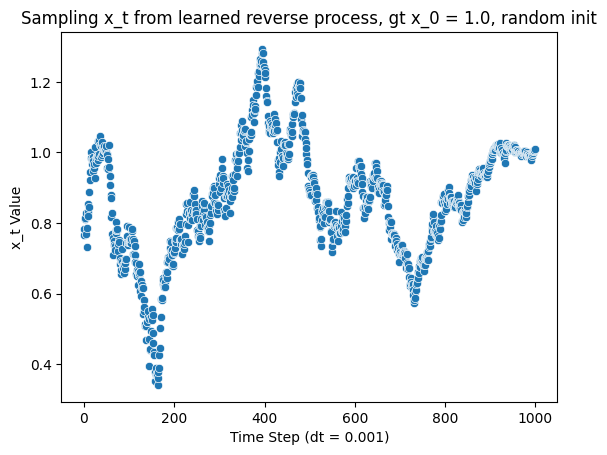

In [ ]:
sns.scatterplot([x for x in range(len(x_t_list))], x_t_list)
plt.xlabel('Time Step (dt = 0.001)')
plt.ylabel('x_t Value')
plt.title('Sampling x_t from learned reverse process, gt x_0 = 1.0, random init')

/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

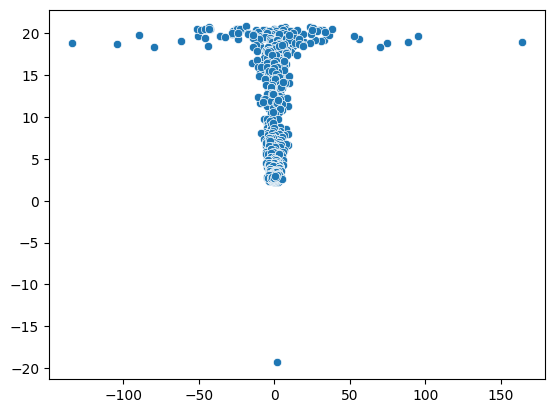

In [ ]:
sns.scatterplot([x.item() for x in gt_scores], [x.detach().cpu().numpy().item() for x in pred_scores])